#Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from sklearn import preprocessing
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

#Load and Read Image

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


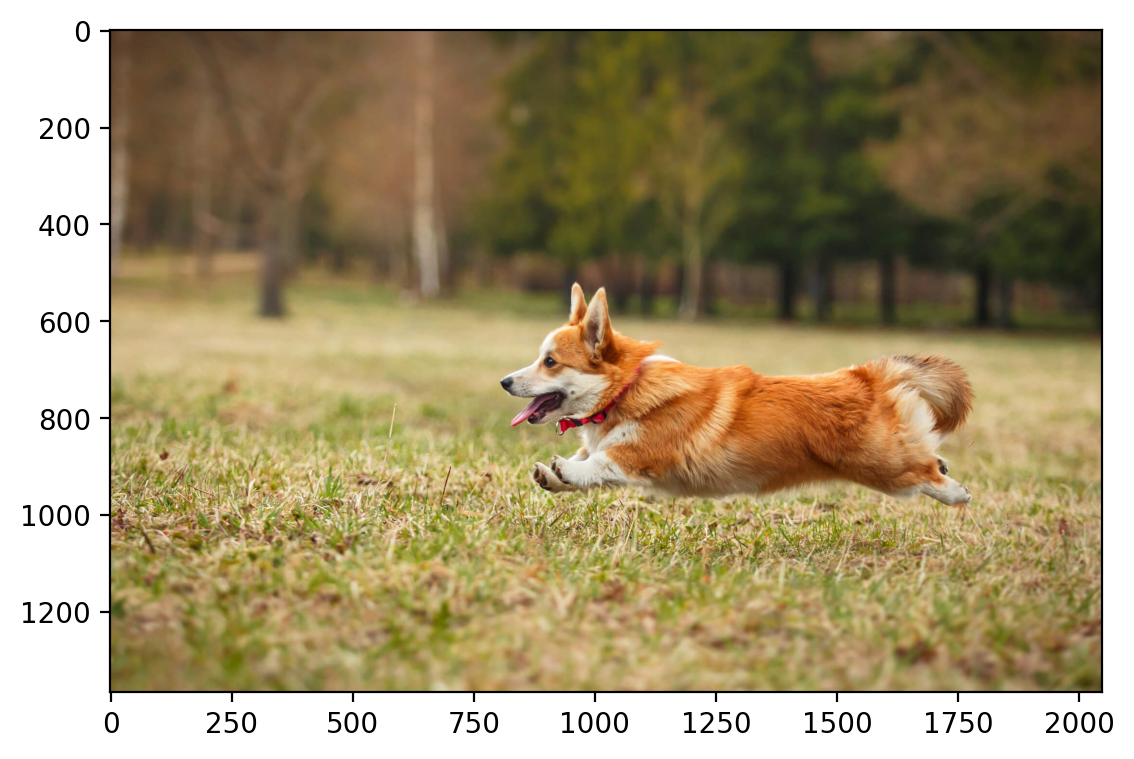

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


#Preprocessing(scaling RGB values and croping image)

In [ ]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
original_img = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 800, 400, 400)
original_img.shape

torch.Size([3, 400, 400])

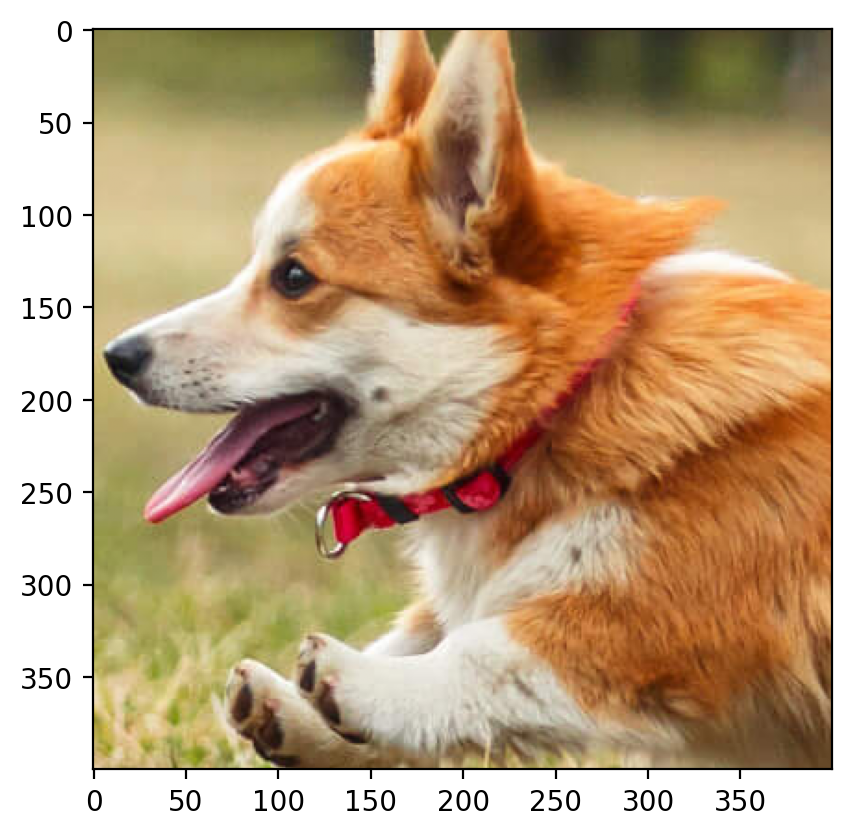

In [ ]:
plt.imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())


In [ ]:
original_img = original_img.to(device)


In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = original_img.shape
print(num_channels, height, width)

3 400 400


In [ ]:
del img
# del scaler_img
# del img_scaled


#Coordinate map and its preprocessing

In [ ]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(original_img)

dog_X.shape, dog_Y.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

#Linear Model

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


#Train function

In [ ]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

#Predict and Plot function

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, scale= 1,title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs.cpu()

#Training

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 100)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
# torch.cuda.empty_cache()

In [ ]:
X_rff = create_rff_features(dog_X_scaled, 8000, 0.008)

In [ ]:
X_rff.shape

torch.Size([160000, 8000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.008, X_rff, dog_Y, 1000)

Epoch 0 loss: 0.344733
Epoch 100 loss: 0.028232
Epoch 200 loss: 0.020717
Epoch 300 loss: 0.018747
Epoch 400 loss: 0.017557
Epoch 500 loss: 0.016752
Epoch 600 loss: 0.016175
Epoch 700 loss: 0.015747
Epoch 800 loss: 0.015419
Epoch 900 loss: 0.015158


0.014946763403713703

#Predicting

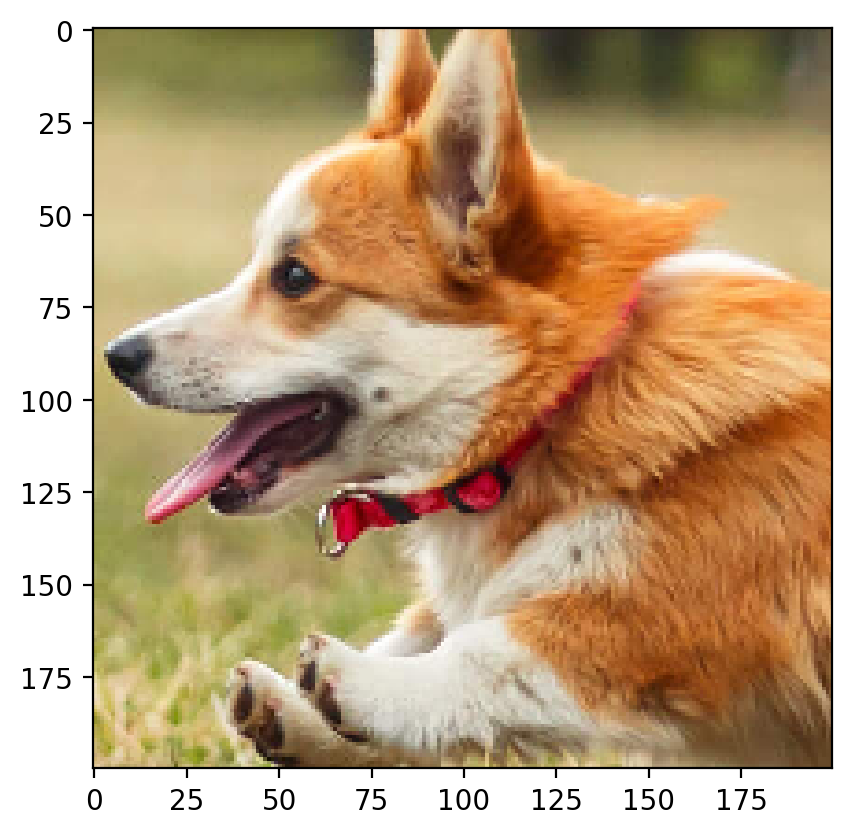

In [ ]:
Y = rearrange(original_img, 'c h w -> h w c').float()
input_img = Y[::2, ::2, :]
plt.imshow(input_img.cpu())

In [ ]:
X_new, y_new = create_coordinate_map(original_img, scale=1)
X_new.size(), y_new.size()

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_new.cpu())

# Scale the X coordinates
X_new_scaled = scaler_X.transform(X_new.cpu())

# Move the scaled X coordinates to the GPU
X_new_scaled = torch.tensor(X_new_scaled).to(device)

# Set to dtype float32
X_new_scaled = X_new_scaled.float()
X_new_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

In [ ]:
X_new_rff = create_rff_features(X_new_scaled, 8000, 0.008)

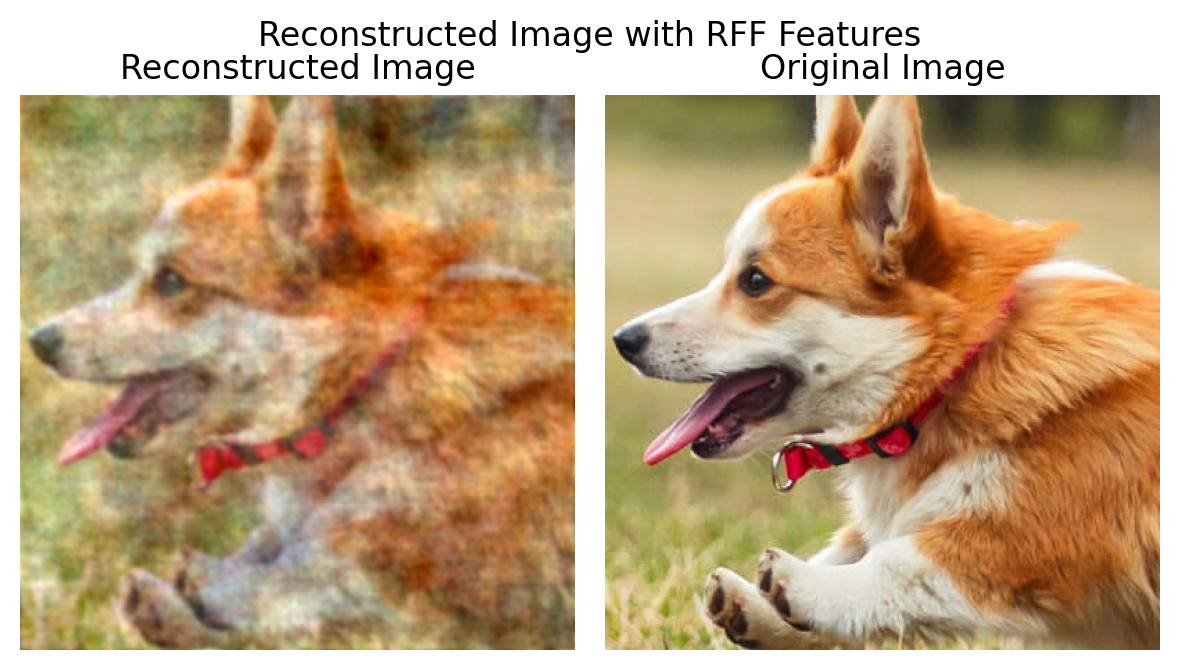

In [ ]:
predicted_image = plot_reconstructed_and_original_image(original_img, net, X_rff, scale = 1,title="Reconstructed Image with RFF Features")

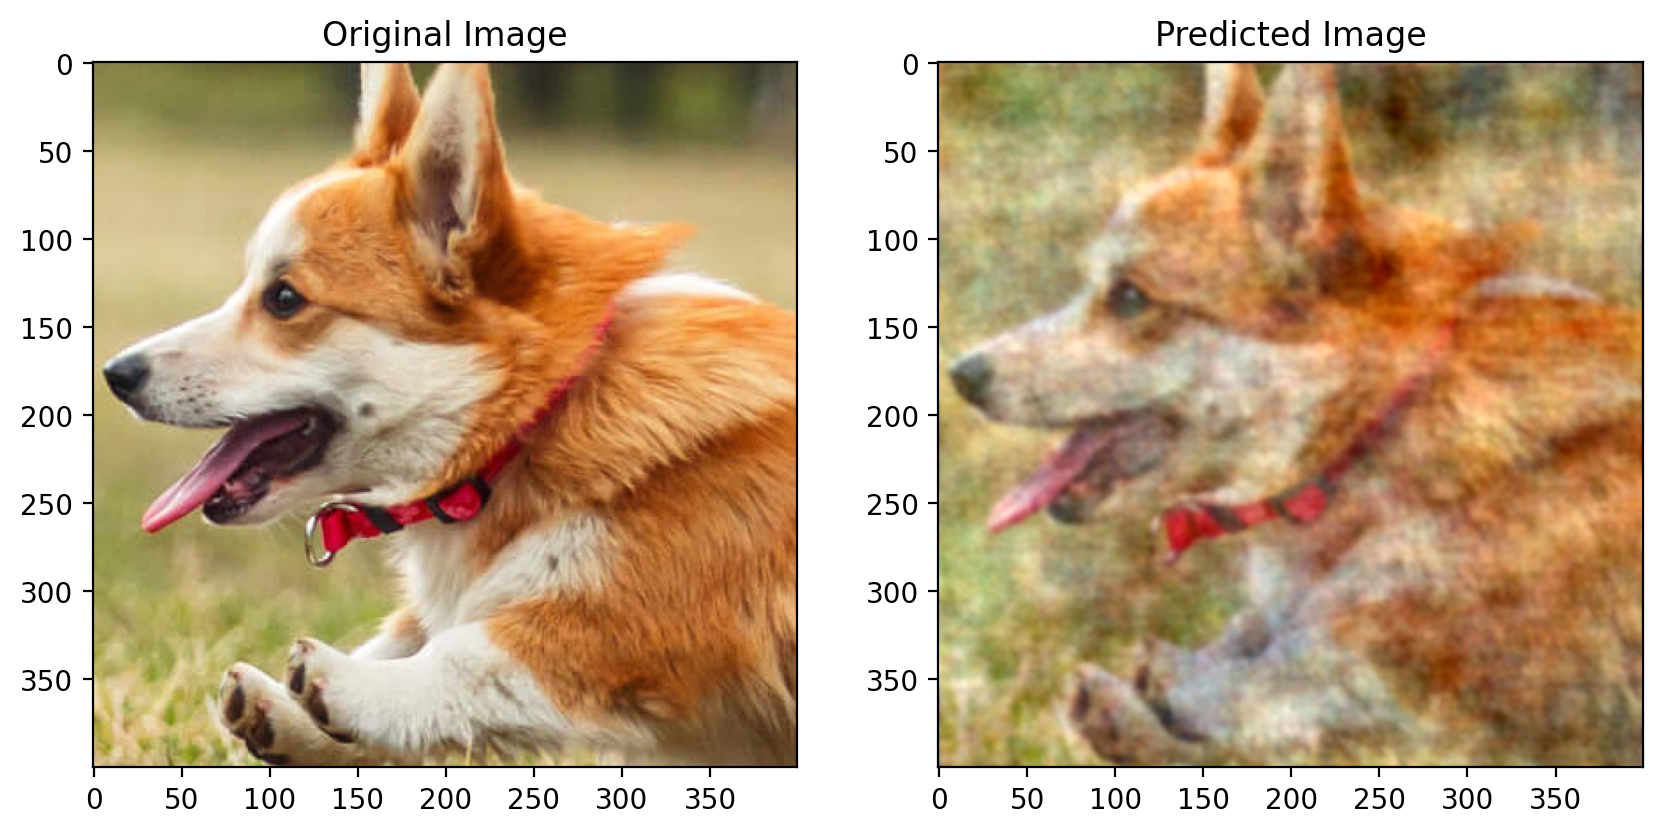

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(rearrange(original_img, 'c h w -> h w c').float().cpu())  # Use 'cmap' based on your image type
plt.title('Original Image')

# Plotting the 'after' image
plt.subplot(1, 2, 2)
plt.imshow(predicted_image.cpu())  # Use 'cmap' based on your image type
plt.title('Predicted Image')


# Display the side-by-side images
plt.show()

In [ ]:
original_img.shape, predicted_image.float().dtype

(torch.Size([3, 400, 400]), torch.float32)

In [ ]:
rmse = np.sqrt(mean_squared_error(rearrange(original_img, 'c h w -> h w c').cpu().numpy(), predicted_image.numpy()))
print("RMSE =", rmse,"\n")

RMSE = 0.12224894790126765 



In [ ]:
psnr = peak_signal_noise_ratio(rearrange(original_img, 'c h w -> h w c').cpu().numpy(), predicted_image.numpy())
print("PSNR =", psnr,"\n")

PSNR = 18.255097396256993 

